In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:\\Users\\HP\\Documents\\KESHTECH\\DSML\\Projects\\Diabetes_Prediction\\Diabetes_Classification\\Datasets\\diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.metrics import classification_report

In [4]:
X = df.drop(columns="Diabetes_binary")
y = df["Diabetes_binary"]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify = y, random_state=42)

# check shapes of split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(63622, 21)
(7070, 21)
(63622,)
(7070,)


In [6]:
X_train_train, X_train_validation, y_train_train, y_train_validation = train_test_split(X_train, y_train, test_size=0.1, stratify = y_train, shuffle=True, random_state=42)

# check shapes of split
print(X_train_train.shape)
print(X_train_validation.shape)
print(y_train_train.shape)
print(y_train_validation.shape)

(57259, 21)
(6363, 21)
(57259,)
(6363,)


In [7]:
# Function to plot the results in further sections

def plot_score(title, x_label):
    # Gather the results of different metrics on the classifier performance
    # Define the name of each metric on the figures
    training_scores = [train_acc_score, train_f1_score, train_precision_score, train_recall_score]
    validation_scores = [validation_acc_score, validation_f1_score, validation_precision_score, validation_recall_score]
    label_name = ['accuracy score', 'f1 score', 'precision score', 'recall score']

    # subplots
    fig, ax = plt.subplots(1, 4, figsize=(40, 10))
    axe = ax.ravel()

    # loop through the lists and plot the 3 figures with corresponding data
    for i, scores in enumerate(zip(training_scores, validation_scores)):

        axe[i].plot(list_parameters, scores[0], c='blue')
        axe[i].plot(list_parameters, scores[1], c='red')
        axe[i].set_title('Influence of ' + title + ' on ' + label_name[i])
        axe[i].set_xlabel(x_label)
        axe[i].set_ylabel(label_name[i])

In [8]:
# Parameter grid for random forest classifier
para_rfc = dict(
    estimator__n_estimators=[100, 200, 300, 400, 500],
    estimator__criterion=['gini', 'entropy', 'log_loss'],
    estimator__max_depth=[*range(1, 20, 2)],
    estimator__min_samples_split=[*range(2, 20, 2)],
    estimator__min_samples_leaf=[*range(1, 20, 2)],
    estimator__max_features=['auto', 'sqrt', 'log2'],
    estimator__bootstrap=[True, False],
    estimator__oob_score=[True, False],
    estimator__ccp_alpha=[a/1000 for a in [*range(0, 15)]]
)

# Parameter grid for gradient boosting
para_gbc = dict(
    estimator__loss=['deviance', 'exponential'],
    estimator__learning_rate=[0.01, 0.1, 0.2, 0.3],
    estimator__n_estimators=[100, 200, 300],
    estimator__criterion=['friedman_mse', 'mse', 'mae'],
    estimator__max_depth=[*range(1, 10)],
    estimator__min_samples_split=[*range(2, 20, 2)],
    estimator__min_samples_leaf=[*range(1, 20, 2)],
    estimator__subsample=[0.7, 0.8, 0.9, 1.0],
    estimator__max_features=['auto', 'sqrt', 'log2']
)

# Parameter grid for ADABoost
para_abc = dict(
    estimator__n_estimators=[50, 100, 150, 200],
    estimator__learning_rate=[0.01, 0.1, 0.2, 0.3, 1.0],
    estimator__algorithm=['SAMME', 'SAMME.R']
)


# Parameter grid for XGBoost
para_xgb = dict(
    estimator__booster=['gbtree', 'gblinear', 'dart'],
    estimator__learning_rate=[0.01, 0.1, 0.2, 0.3],
    estimator__n_estimators=[100, 200, 300],
    estimator__max_depth=[*range(1, 20, 2)],
    estimator__min_child_weight=[1, 2, 3, 4],
    estimator__gamma=[0, 0.1, 0.2, 0.3, 0.4],
    estimator__subsample=[0.7, 0.8, 0.9, 1.0],
    estimator__colsample_bytree=[0.7, 0.8, 0.9, 1.0],
    estimator__reg_alpha=[0, 0.01, 0.1, 1],
    estimator__reg_lambda=[1, 1.5, 2, 3]
)

# parameter grids for decision tree
para_dtc = dict(
    estimator__criterion=['gini', 'entropy', 'log_loss'],
    estimator__splitter=['best', 'random'],
    estimator__max_depth=[*range(1, 10)],
    estimator__min_samples_split=[*range(10, 20, 10)],
    estimator__min_samples_leaf=[*range(10, 20, 10)],
    estimator__ccp_alpha=[a/1000 for a in [*range(0, 15)]]
)

# parameter grids for KNN
para_knc = dict(
    estimator__n_neighbors=[*range(1,15)],
    estimator__weights=['uniform', 'distance'],
    estimator__p=[*range(1, 4)]
)

# parameter grids for SVM with "rbf" kernel
para_svc_rbf = dict(
    estimator__kernel=['rbf'],
    estimator__gamma=['scale', 'auto'],
    estimator__C = [1, 2, 3, 4, 5]
)

# parameter grids for SVM with "poly" kernel
para_svc_poly = dict(
    estimator__kernel=['poly'],
    estimator__degree=[*range(1, 4)],
    estimator__gamma=['scale', 'auto'],
    estimator__C = [1, 2, 3, 4, 5]
)

In [9]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler

def get_pipe(estimator):

    """
    Data passed to this pipeline would be scaled by MinMaxScaler before the classifier
    """
    return Pipeline([('scaler', MinMaxScaler()), ('estimator', estimator)])

In [10]:
def nested_cv(clf, para_grid, num_trials=5, num_repeats=5, search_num_split=5, cv_num_split=5):

    """
    Input:
    1. clf = classifier
    2. para_grid = corresponding grid of hyperparameters
    3. num_trials = number of trials for outer cv
    4. num_repeats = number of repeats for folds in outer cv
    5. search_num_split = number of splits in inner search cv
    6. cv_num_split = number of split for outer cv

    Output:
    Means and standard deviations of
    1. fit time
    2. score time
    3. accuracy score
    4. f1 score
    5. recall score

    Folding strategies are:
    Inner cv = StratifiedKFold
    Outer cv = RepeatedStratifiedKFold

    Search Model = Random Search cv (To save computing resources) but return reasonable robust results at the same time
    Number of iteration in the search model (Number of random parameter samples) = 10

    F1 score is chosen to be the refit metrics in search cv
    Although recall score is the most important score, the model might be trained to classify all the input as positive to avoid any false negative.
    (High Recall scores but lower precision score)

    Process:
    Classifier is fitted to pipeline function, "get_pipe"
    """

    # fit classifier to pipeline function defined previously
    pipe = get_pipe(clf)

    # prepare empty lists to store the results
    fit_time, score_time = [], []
    test_score_acc, test_score_f1, test_score_recall = [], [], []

    # apply for loop to run the whole nested cv
    for i in range(num_trials):

        # Fold method for inner cv
        skf = StratifiedKFold(
            n_splits=search_num_split,
            shuffle=True,
            random_state=73+i
        )

        # Fold method of outer cv
        rskf = RepeatedStratifiedKFold(
            n_splits=cv_num_split,
            n_repeats=num_repeats,
            random_state=73+i
        )

        # fit pipeline to search cv
        # fit the corresponding parameter grids to the classifier
        # use StratifiedKFold be splitting strategy
        # use f1 as refit score to search the best hyperparameter combinations
        search_cv = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=para_grid,
            cv=skf,
            scoring="f1",
            refit="f1",
            random_state=73+i
        )

        # fit X_train and y_train data to cv
        # X_train is not scaled here, but is scaled when passes through pipeline inside random search cv
        # track 3 metrics
        cv = cross_validate(
            estimator=search_cv,
            X=X_train,
            y=y_train,
            cv=rskf,
            scoring=["accuracy", "f1", "recall"]
        )

        # Store results to the corresponding lists prepared
        fit_time.append(cv['fit_time'])
        score_time.append(cv['score_time'])
        test_score_acc.append(cv['test_accuracy'])
        test_score_f1.append(cv['test_f1'])
        test_score_recall.append(cv['test_recall'])


    # Store mean fit and score time
    mean_fit_time = np.mean(np.array(fit_time).flatten())
    mean_score_time = np.mean(np.array(fit_time).flatten())

    # Store mean and standard deviation of accuracy score
    mean_test_score_acc = np.mean(np.array(test_score_acc).flatten())
    std_test_score_acc = np.std(np.array(test_score_acc).flatten())

    # Store mean and standard deviation of f1 score
    mean_test_score_f1 = np.mean(np.array(test_score_f1).flatten())
    std_test_score_f1 = np.std(np.array(test_score_f1).flatten())

    # Store mean and standard deviation of recall score
    mean_test_score_recall = np.mean(np.array(test_score_recall).flatten())
    std_test_score_recall = np.std(np.array(test_score_recall).flatten())

    # return all the results stored
    return [mean_fit_time, mean_score_time, mean_test_score_acc, std_test_score_acc, mean_test_score_f1, std_test_score_f1, mean_test_score_recall, std_test_score_recall]

#### SVM poly - Grid Search CV

In [ ]:
# # fit the final production model to pipeline
# # input data is scaled by MinMaxScaler in each split in CV
# pipe = get_pipe(XGBClassifier())

# # prepare grid of parameters and split numbers
# para_grid = para_xgb
# num_splits = 5
# num_repeats = 5

# # Fold strategy for outer cv
# rskf = RepeatedStratifiedKFold(
#     n_splits=num_splits,
#     n_repeats=num_repeats,
#     random_state=73
# )

# # fit pipeline and grid to Grid Search CV
# search_cv = GridSearchCV(
#     estimator=pipe,
#     param_grid=para_grid,
#     return_train_score=True,
#     scoring=["accuracy", "f1", "recall"],
#     refit='f1',
#     cv=rskf,
#     n_jobs=4
# )

# # fit original training set to the search model
# search_cv.fit(X_train, y_train)

#### Best Hyperparameters

In [ ]:
# # Checking the combination of parameters, which generated the best result
# print(search_cv.best_params_)

In [ ]:
# # Using pipeline to fit the model with MinMaxScaling
# # Fitting original training set to the best model

# best_clf = search_cv.best_estimator_
# pipe_clf = make_pipeline(MinMaxScaler(), best_clf)
# pipe_clf.fit(X_train, y_train)

In [16]:
pipe_xgb3 = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(
        booster='gblinear',
        learning_rate=0.2,
        n_estimators=100,
        max_depth=7,
        min_child_weight=4,
        gamma=0.2,
        subsample=0.7,
        colsample_bytree=0.9,
        reg_alpha=1,
        reg_lambda=3
    )
)
pipe_xgb3.fit(X_train, y_train)

[00:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.9,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [12]:
pipe_xgb2 = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(
        booster='dart',
        learning_rate=0.3,
        n_estimators=300,
        max_depth=10,
        min_child_weight=3,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        reg_lambda=2
    )
)
pipe_xgb2.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='dart', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.3, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=3, missing=nan,
                               monotone_constraints=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [13]:
pipe_xgb1 = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(
        booster='gbtree',
        learning_rate=0.1,
        n_estimators=200,
        max_depth=5,
        min_child_weight=2,
        gamma=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1.5
    )
)
pipe_xgb1.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.8,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [17]:
# result of fitting original training set
print(classification_report(y_train, pipe_xgb1.predict(X_train)))
print("===============================================================")
print(classification_report(y_train, pipe_xgb2.predict(X_train)))
print("===============================================================")
print(classification_report(y_train, pipe_xgb3.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.79      0.72      0.76     31811
         1.0       0.75      0.81      0.78     31811

    accuracy                           0.77     63622
   macro avg       0.77      0.77      0.77     63622
weighted avg       0.77      0.77      0.77     63622

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     31811
         1.0       0.94      0.94      0.94     31811

    accuracy                           0.94     63622
   macro avg       0.94      0.94      0.94     63622
weighted avg       0.94      0.94      0.94     63622

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     31811
         1.0       0.00      0.00      0.00     31811

    accuracy                           0.50     63622
   macro avg       0.25      0.50      0.33     63622
weighted avg       0.25      0.50      0.33     63622



##### Test Set

In [18]:
# result of fitting original testing set
print(classification_report(y_test, pipe_xgb1.predict(X_test)))
print("===============================================================")
print(classification_report(y_test, pipe_xgb2.predict(X_test)))
print("===============================================================")
print(classification_report(y_test, pipe_xgb3.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.73      3535
         1.0       0.72      0.80      0.76      3535

    accuracy                           0.75      7070
   macro avg       0.75      0.75      0.75      7070
weighted avg       0.75      0.75      0.75      7070

              precision    recall  f1-score   support

         0.0       0.72      0.69      0.71      3535
         1.0       0.71      0.74      0.72      3535

    accuracy                           0.71      7070
   macro avg       0.71      0.71      0.71      7070
weighted avg       0.71      0.71      0.71      7070

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      3535
         1.0       0.00      0.00      0.00      3535

    accuracy                           0.50      7070
   macro avg       0.25      0.50      0.33      7070
weighted avg       0.25      0.50      0.33      7070



In [19]:
# Extract XGBoost classifiers from the pipelines
xgb1 = pipe_xgb1.named_steps['xgbclassifier']
xgb2 = pipe_xgb2.named_steps['xgbclassifier']
xgb3 = pipe_xgb3.named_steps['xgbclassifier']

In [20]:
# Get feature importances from XGBoost classifiers
xgb1_importances = xgb1.feature_importances_
xgb2_importances = xgb2.feature_importances_
xgb3_importances = xgb3.feature_importances_

In [21]:
features = X_train.columns

# Create DataFrame for XGBoost importances
df_xgb = pd.DataFrame({
    'Feature': features,
    'XGB1_Importance': xgb1_importances,
    'XGB2_Importance': xgb2_importances,
    'XGB3_Importance': xgb3_importances
})

In [22]:
df_xgb

,Feature,XGB1_Importance,XGB2_Importance,XGB3_Importance
0,HighBP,0.432197,0.117807,0.0
1,HighChol,0.111402,0.082789,0.0
2,CholCheck,0.034216,0.084022,0.0
3,BMI,0.034638,0.045005,0.0
4,Smoker,0.006780,0.029956,0.0
5,Stroke,0.009186,0.034438,0.0
6,HeartDiseaseorAttack,0.029917,0.045922,0.0
7,PhysActivity,0.006562,0.030894,0.0
8,Fruits,0.005840,0.030197,0.0
9,Veggies,0.005581,0.030306,0.0


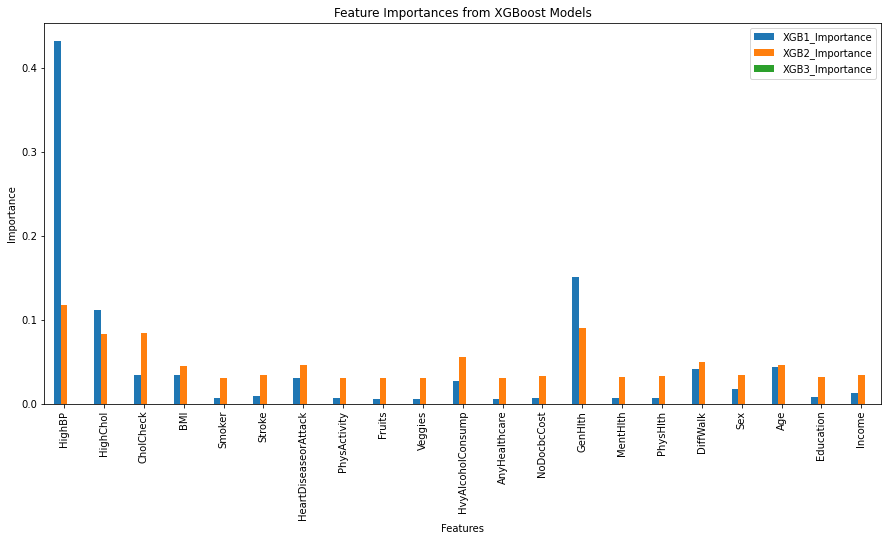

In [23]:
# Plot XGBoost feature importances
df_xgb.set_index('Feature').plot(kind='bar', figsize=(15, 7))
plt.title('Feature Importances from XGBoost Models')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()